In [376]:
import os
import warnings
from joblib import load
from utils.plot import *
from utils.scaler import *
from sklearn.metrics import *
from matplotlib import pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

In [377]:
plt.rc('font', family='GULIM')
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

In [388]:
# X_test = pd.read_csv('Database/test/X_self_test_norm.csv', index_col=0)
X_test = pd.read_csv('Database/test/X_real_test_norm.csv', index_col=0)
y_test = pd.read_csv('Database/test/y_self_test.csv', index_col=0)
target_scaler = load('Database/target_scaler.joblib')
y_test = pd.DataFrame(target_scaler.inverse_transform(y_test), index=y_test.index)

In [389]:
y_test = inverse_boxcox(y_test, -0.4431146771093272) - 0.000001
# y_test=pd.DataFrame(np.exp(y_test)-1)

# Best-model dict 저장

In [390]:
STN_list = ['STN001', 'STN002', 'STN003', 'STN004', 'STN005', 'STN006', 'STN007', 'STN008', 'STN009', 'STN010',
            'STN011', 'STN012', 'STN013', 'STN014', 'STN015', 'STN016', 'STN017', 'STN018', 'STN019', 'STN020']

GMM_list = [f'GMM{i}' for i in range(15)]

dt_files = sorted(filename for filename in os.listdir('File/DT') if filename.endswith('.pkl'))
lgb_files = sorted(filename for filename in os.listdir('File/LGBM') if filename.endswith('.pkl'))
xgb_files = sorted(filename for filename in os.listdir('File/XGB') if filename.endswith('.pkl'))
cat_files = sorted(filename for filename in os.listdir('File/CAT') if filename.endswith('.pkl'))

best_dt_dict = {}
best_lgb_dict = {}
best_xgb_dict = {}
# best_cat_dict = {}

for i, STN in enumerate(GMM_list):
    best_dt_dict[STN] = load(os.path.join('File/DT', dt_files[i]))
    best_lgb_dict[STN] = load(os.path.join('File/LGBM', lgb_files[i]))
    best_xgb_dict[STN] = load(os.path.join('File/XGB', xgb_files[i]))
    # best_cat_dict[STN] = load(os.path.join('File/CAT', cat_files[i]))

# BoxCox 역변환 & 예측값 dict 저장

## 표준화 역변환

In [391]:
pred_dt_dict = {}
pred_lgb_dict = {}
pred_xgb_dict = {}
# pred_cat_dict = {}

for i, STN in enumerate(GMM_list):
    pred_dt_dict[STN] = pd.DataFrame(target_scaler.inverse_transform(best_dt_dict[STN].predict(X_test).reshape(-1, 1)))
    pred_lgb_dict[STN] = pd.DataFrame(target_scaler.inverse_transform(best_dt_dict[STN].predict(X_test).reshape(-1, 1)))
    pred_xgb_dict[STN] = pd.DataFrame(target_scaler.inverse_transform(best_dt_dict[STN].predict(X_test).reshape(-1, 1)))
    # pred_cat_dict[STN] = pd.DataFrame(target_scaler.inverse_transform(best_dt_dict[STN].predict(X_test).reshape(-1, 1)))

## BoxCox or log 역변환

In [355]:
# BoxCox 역변환
for i, STN in enumerate(GMM_list):
    pred_dt_dict[STN] = inverse_boxcox(pd.DataFrame(pred_dt_dict[STN]), -0.4431146771093272) - 0.000001
    pred_lgb_dict[STN] = inverse_boxcox(pd.DataFrame(pred_lgb_dict[STN]), -0.4431146771093272) - 0.000001
    pred_xgb_dict[STN] = inverse_boxcox(pd.DataFrame(pred_xgb_dict[STN]), -0.4431146771093272) - 0.000001
    # pred_cat_dict[STN] = inverse_boxcox(pd.DataFrame(pred_cat_dict[STN]), -0.4431146771093272) - 0.000001

# log 역변환
# for i, STN in enumerate(STN_list):
#     pred_dt_dict[STN] = pd.DataFrame(np.exp(pred_dt_dict[STN])-1)
#     pred_lgb_dict[STN] = pd.DataFrame(np.exp(pred_lgb_dict[STN])-1)
#     pred_xgb_dict[STN] = pd.DataFrame(np.exp(pred_xgb_dict[STN])-1)
#     pred_cat_dict[STN] = pd.DataFrame(np.exp(pred_cat_dict[STN])-1)

# 아무것도 안했을 때
# for i, STN in enumerate(STN_list):
#     pred_dt_dict[STN] = pd.DataFrame(best_dt_dict[STN].predict(X_test))
#     pred_lgb_dict[STN] = pd.DataFrame(best_lgb_dict[STN].predict(X_test))
#     pred_xgb_dict[STN] = pd.DataFrame(best_xgb_dict[STN].predict(X_test))
#     pred_cat_dict[STN] = pd.DataFrame(best_cat_dict[STN].predict(X_test))

# 60개 싱글모델 예측값 DataFrame 저장

In [392]:
prediction_df = pd.DataFrame()
for i, STN in enumerate(GMM_list):
    prediction_df = pd.concat(
        [prediction_df,
         pd.DataFrame(pred_dt_dict[STN].values, columns=[f'DT_{STN}']),
         pd.DataFrame(pred_lgb_dict[STN].values, columns=[f'lgb_{STN}']),
         pd.DataFrame(pred_xgb_dict[STN].values, columns=[f'xgb_{STN}']),
         # pd.DataFrame(pred_cat_dict[STN].values, columns=[f'cat_{STN}'])
         ], axis=1)

prediction_df.index = X_test.index

# 60개 싱글모델 metric DataFrame 저장

In [382]:
metric_df = pd.DataFrame(columns=['R2', 'RMSE', 'MAE', 'MAPE'])
for i, STN in enumerate(GMM_list):
    metric_df = pd.concat(
        [metric_df, pd.DataFrame([r2_score(y_test.values, pred_dt_dict[STN]),
                                  root_mean_squared_error(y_test.values, pred_dt_dict[STN]),
                                  mean_absolute_error(y_test.values, pred_dt_dict[STN]),
                                  mean_absolute_percentage_error(y_test.values, pred_dt_dict[STN])],
                                 index=metric_df.columns, columns=[f'DT_{STN}']).T], axis=0)

    metric_df = pd.concat(
        [metric_df, pd.DataFrame([r2_score(y_test.values, pred_lgb_dict[STN]),
                                  root_mean_squared_error(y_test.values, pred_lgb_dict[STN]),
                                  mean_absolute_error(y_test.values, pred_lgb_dict[STN]),
                                  mean_absolute_percentage_error(y_test.values, pred_lgb_dict[STN])],
                                 index=metric_df.columns, columns=[f'LGB_{STN}']).T], axis=0)

    metric_df = pd.concat(
        [metric_df, pd.DataFrame([r2_score(y_test.values, pred_xgb_dict[STN]),
                                  root_mean_squared_error(y_test.values, pred_xgb_dict[STN]),
                                  mean_absolute_error(y_test.values, pred_xgb_dict[STN]),
                                  mean_absolute_percentage_error(y_test.values, pred_xgb_dict[STN])],
                                 index=metric_df.columns, columns=[f'XGB_{STN}']).T], axis=0)

    # metric_df = pd.concat(
    #     [metric_df, pd.DataFrame([r2_score(y_test.values, pred_cat_dict[STN]),
    #                               root_mean_squared_error(y_test.values, pred_cat_dict[STN]),
    #                               mean_absolute_error(y_test.values, pred_cat_dict[STN]),
    #                               mean_absolute_percentage_error(y_test.values, pred_cat_dict[STN])],
    #                              index=metric_df.columns, columns=[f'CAT_{STN}']).T], axis=0)

# Deep Learning 단일모델 시험

In [383]:
# from Module.model import *
# 
# backbone = MLP(input_size=57, hidden_size=512, output_size=1).to('cuda')
# backbone.load_state_dict(torch.load('Weight/STN001.pth'))
# backbone.eval()
# output = backbone(torch.tensor(X_test.values).to('cuda'))
# 
# output = output.cpu().detach().numpy()
# output = target_scaler.inverse_transform(output)
# output = inverse_boxcox(output, -0.4431146771093272) - 0.000001
# output = np.exp(output)-1
# prediction_df2 = pd.DataFrame(output, index=X_test.index)

# Fuzzy Membership

In [384]:
def fuzzy_membership(prediction_df, gt_df):
    total_df = pd.concat([prediction_df, gt_df], axis=1)
    errors = np.array(
        [np.abs((gt - pred)) for gt, pred in zip(total_df.iloc[:, -1].values, total_df.iloc[:, :-1].values)])
    errors_df = pd.DataFrame(errors, index=total_df.index, columns=prediction_df.columns)
    std_df = errors_df.apply(lambda col: np.std(col))
    membership_df = errors_df.apply(lambda x: np.exp(-x ** 2 / (2 * std_df[x.name] ** 2)), axis=0)
    fixed_weights = membership_df.mean(axis=0)

    ensemble_pred = np.average(prediction_df, axis=1, weights=membership_df)
    ensemble_pred_df = pd.DataFrame(ensemble_pred, columns=['Prediction'], index=prediction_df.index)

    return ensemble_pred_df, fixed_weights

In [341]:
final_pred_df, membership_df = fuzzy_membership(prediction_df, y_test)
# membership_df.to_csv('Database/fuzzy_membership.csv')

# CSI 계산

In [385]:
pred_rating_df = prediction_df.applymap(lambda x: map_values(x))
truth_rating_df = pd.DataFrame(y_test).applymap(lambda x: map_values(x))
data = pd.concat([pred_rating_df.iloc[:, 0], truth_rating_df], axis=1)

In [386]:
mapping = {
    0: "<0.1",
    1: "0.1<=X<0.2",
    2: "0.2<=X<0.5",
    3: "0.5<=X<1",
    4: "1<=X<2",
    5: "2<=X<5",
    6: "5<=X<10",
    7: "10<=X<20",
    8: "20<=X<30",
    9: "X>=30"
}

data['predicted'] = data.iloc[:, 0].map(mapping)
data['observed'] = data.iloc[:, 1].map(mapping)

csi_categories = ["<0.1", "0.1<=X<0.2", "0.2<=X<0.5", "0.5<=X<1", "1<=X<2", "2<=X<5", "5<=X<10", "10<=X<20", "20<=X<30",
                  "X>=30"]
csi_table = pd.DataFrame(0, index=csi_categories, columns=csi_categories)

for index, row in data.iterrows():
    observed = row['observed']
    predicted = row['predicted']
    csi_table.at[observed, predicted] += 1

In [387]:
cal_CSI(csi_table)

0.03708771072562912

# Real-test prediction 저장

In [369]:
membership_df = pd.read_csv('Database/fuzzy_membership.csv', index_col=0)
ensemble_pred = np.average(prediction_df, axis=1, weights=membership_df.values.flatten())
final_pred_df = pd.DataFrame(ensemble_pred, columns=['Prediction'], index=prediction_df.index)
pred_rating_df = final_pred_df.applymap(lambda x: map_values(x))

In [395]:
submssion_df = pd.read_csv('Database/rainfall_test.csv')
submssion_df.loc[pred_rating_df.index, 'rainfall_test.class_interval'] = pred_rating_df['Prediction']

KeyError: 'Prediction'

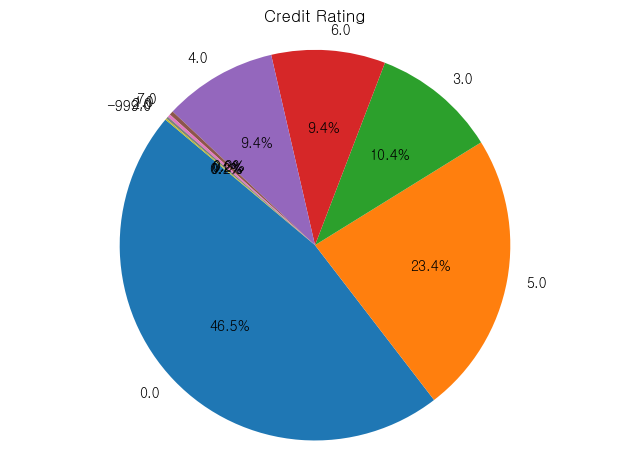

In [371]:
plot_imabalance(submssion_df, 'rainfall_test.class_interval')

In [301]:
submssion_df.to_csv('File/240105.csv', index=False)

In [394]:
pred_rating_df = prediction_df.applymap(lambda x: map_values(x))

In [397]:
submssion_df = pd.read_csv('Database/rainfall_test.csv')
submssion_df.loc[pred_rating_df.index, 'rainfall_test.class_interval'] = pred_rating_df['DT_GMM0']

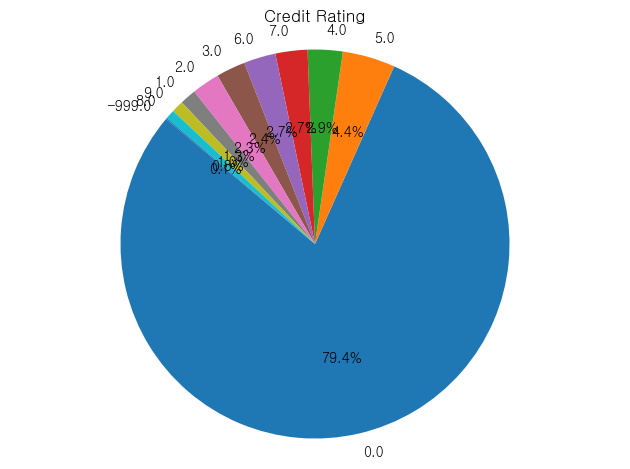

In [398]:
plot_imabalance(submssion_df, 'rainfall_test.class_interval')